1. OPENING FITS FILE AND GETTING ITS INFORMATION.

In [2]:
%pip install astropy numpy

Note: you may need to restart the kernel to use updated packages.


In [3]:
from astropy.io import fits
import numpy as np

# Opening the FITS file
fits_file = "C:\TASK_VSSC\hst_9789_04_acs_wfc_total_sci.fits"
hdul = fits.open(fits_file)


<>:5: SyntaxWarning: invalid escape sequence '\T'
<>:5: SyntaxWarning: invalid escape sequence '\T'
C:\Users\tanis\AppData\Local\Temp\ipykernel_2804\1836963456.py:5: SyntaxWarning: invalid escape sequence '\T'
  fits_file = "C:\TASK_VSSC\hst_9789_04_acs_wfc_total_sci.fits"


In [4]:
hdul.info()

Filename: C:\TASK_VSSC\hst_9789_04_acs_wfc_total_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     864   ()      
  1  SCI           1 ImageHDU        83   (5352, 5897)   float32   


In [5]:
hdul[1].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 5352                                                  
NAXIS2  =                 5897                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
INHERIT =                    T / inherit the primary header                     
EXTNAME = 'SCI     '           / extension name                                 
EXTVER  =                    1                                                  
BUNIT   = 'ELECTRONS/S'        / Units of science product                       
                                                                                
CD1_1   = -1.3888888888888E-

In [6]:
# hdul[0].header

In [7]:
data=hdul[1].data

In [8]:
type(data)

numpy.ndarray

In [9]:
hdul.close()
print(f"Image shape: {data.shape}")
print(data.dtype)
print(data.dtype.name)
print(data.size)
print(data.ndim)

Image shape: (5897, 5352)
>f4
float32
31560744
2


2. IMAGE PROCESSING

In [10]:
%pip install scikit-image opencv-python

Trying different sigma values.

In [11]:
# from scipy.ndimage import gaussian_filter
# import matplotlib.pyplot as plt

# # Try different sigma values
# for sigma in [0.1, 2, 3, 4]:
#   smoothed_image = gaussian_filter(data, sigma=sigma)
#   plt.figure(figsize=(6, 6))
#   plt.imshow(smoothed_image, cmap='gray')
#   plt.title(f'Sigma = {sigma}')
#   plt.show()

APPLYING GAUSSIAN FILTER:

In [12]:
from scipy.ndimage import gaussian_filter

roi_start_x, roi_end_x = 1500, 4000
roi_start_y, roi_end_y = 1500, 4500
data_subset = data[roi_start_y:roi_end_y, roi_start_x:roi_end_x]

# Gaussian filter to smooth the image
smoothed_image = gaussian_filter(data_subset, sigma=1)


ADAPTIVE THRESHOLDING

In [13]:
from skimage.filters import threshold_local

# Adaptive thresholding with a block size for threshold calculation
adaptive_thresh = threshold_local(smoothed_image, block_size=25, offset=0)
binary_image = smoothed_image > adaptive_thresh


In [14]:
# from skimage.morphology import binary_dilation, binary_erosion
# import numpy as np

# # Apply binary dilation to expand detected objects slightly
# dilated_image = binary_dilation(binary_image, footprint=np.ones((3, 3)))

# # Apply binary erosion to remove small noise (optional)
# cleaned_image = binary_erosion(dilated_image, footprint=np.ones((3, 3)))


DBSCAN (Density-Based Spatial Clustering of Applications with Noise) clustering

In [15]:
from sklearn.cluster import DBSCAN
import numpy as np

# Get coordinates of all potential objects in the binary image
coords = np.column_stack(np.where(binary_image > 0))

# Apply DBSCAN clustering to find groups of pixels that belong to objects
db = DBSCAN(eps=7, min_samples=10).fit(coords)
labels = db.labels_

# Create labeled image 
labeled_image = np.zeros_like(binary_image, dtype=int)
for label, (y, x) in zip(labels, coords):
    if label != -1:  # -1 is noise in DBSCAN
        labeled_image[y, x] = label + 1


PLOTTING AND FEATURE EXTRACTION (Measuring Object Properties)

{'Object_ID': 1, 'X': np.float64(605.1040511255735), 'Y': np.float64(1627.2876409114547), 'Size': np.float64(1746132.0), 'Luminosity': np.float32(0.18760692)}
{'Object_ID': 2, 'X': np.float64(1846.163767365214), 'Y': np.float64(1373.1153135655447), 'Size': np.float64(1895744.0), 'Luminosity': np.float32(0.18584883)}
{'Object_ID': 3, 'X': np.float64(1555.4193548387098), 'Y': np.float64(136.4516129032258), 'Size': np.float64(31.0), 'Luminosity': np.float32(1.1891869)}
{'Object_ID': 4, 'X': np.float64(2040.7575757575758), 'Y': np.float64(301.0), 'Size': np.float64(33.0), 'Luminosity': np.float32(0.71106285)}
{'Object_ID': 5, 'X': np.float64(1775.8857142857144), 'Y': np.float64(936.8857142857142), 'Size': np.float64(35.0), 'Luminosity': np.float32(20.312983)}
{'Object_ID': 6, 'X': np.float64(653.5), 'Y': np.float64(1061.5), 'Size': np.float64(32.0), 'Luminosity': np.float32(26.372974)}
{'Object_ID': 7, 'X': np.float64(689.5), 'Y': np.float64(1120.5), 'Size': np.float64(32.0), 'Luminosity':

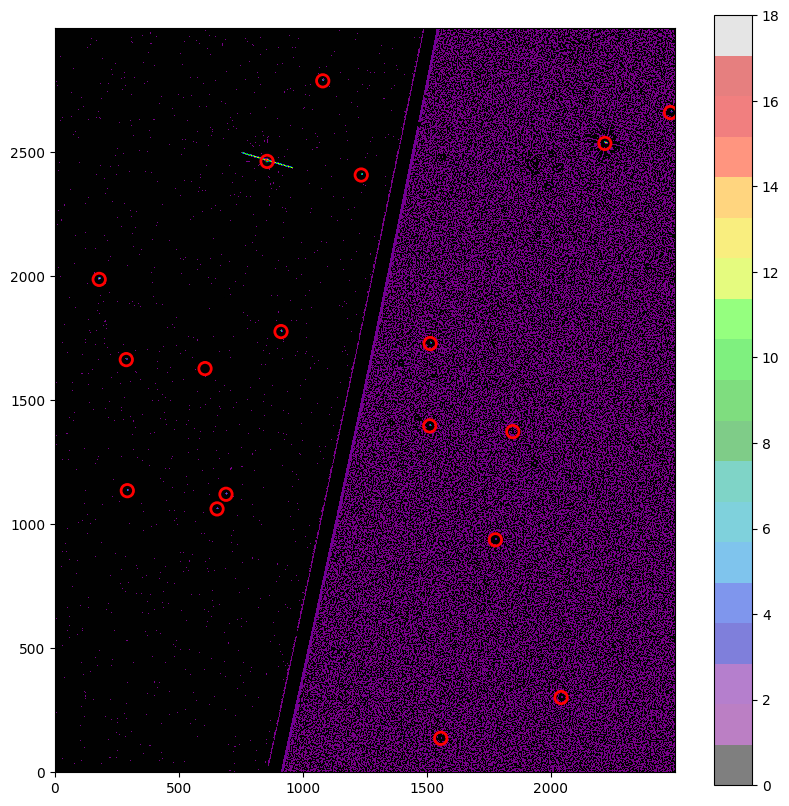

Number of detected objects: 18


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from skimage.measure import regionprops  
from matplotlib.patches import Circle

# Compute region properties (centroids, equivalent diameters)
regions = regionprops(labeled_image, intensity_image=data_subset) 

# Plot the original image
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(data_subset, cmap='gray', origin='lower')

# Overlay the detected objects using labeled_image
colors = plt.cm.nipy_spectral(np.linspace(0, 1, labeled_image.max() + 1))
colors[0, -1] = 0  # Transparent background
label_cmap = ListedColormap(colors)

ax.imshow(labeled_image, cmap=label_cmap, alpha=1, origin='lower')


# Prepare a list to hold object features
objects_data = []


# Mark circles around detected objects
for region in regions:
    
        
    # Get the centroid of the object
    y0, x0 = region.centroid
    radius = 25
    # Draw a circle around the detected object
    circle = Circle((x0, y0), radius, color='red', fill=False, linewidth=2)
    ax.add_patch(circle)

    # Extract properties: centroid, area, and mean intensity (luminosity)
    centroid = region.centroid
    area = region.area
    luminosity = region.mean_intensity  # Mean pixel value within the object

    objects_data.append({
        'Object_ID': region.label,
        'X': centroid[1],  # x-coordinate of centroid
        'Y': centroid[0],  # y-coordinate of centroid
        'Size': region.area ,
        'Luminosity': luminosity
    })

for obj in objects_data: #displaying objects

    print(obj)

plt.colorbar(ax.imshow(labeled_image, cmap=label_cmap, alpha=0.5, origin='lower'))
plt.show()

# Print the number of detected objects
print(f"Number of detected objects: {labeled_image.max()}")


In [17]:
#I downloaded csv file previously from kaggle then formed a github repository. 
import pandas as pd

# Convert the object data into a DataFrame
df = pd.DataFrame(objects_data)

# Save the DataFrame to a CSV file
output_file = 'celestial_objects.csv'
df.to_csv(output_file, index=False)

print(f"Data saved to {output_file}")

import shutil

# Move the file to a known location (optional)
shutil.move('celestial_objects.csv', '/kaggle/working/celestial_objects.csv')


Data saved to celestial_objects.csv


FileNotFoundError: [WinError 3] The system cannot find the path specified